# **Introduction to convolutional neural network (CNN)**

Convolutional neural network is a Deep Learning algorithm which can take in an input image, assign importance (learnable weights and biases) to various aspects/objects in the image and be able to differentiate one from the other.

![](https://miro.medium.com/max/3288/1*uAeANQIOQPqWZnnuH-VEyw.jpeg)

**Convolution operation on a MxNx3 image matrix with a 3x3x3 Kernel**

![](https://miro.medium.com/max/700/1*ciDgQEjViWLnCbmX-EeSrA.gif)

# **Transposed Convolution**

Transposed Convolutions are used to upsample the input feature map to a desired output feature map using some learnable parameters.

It is also referred to as fractionally strided convolution due since stride over the output is equivalent to fractional stride over the input. For instance, a stride of 2 over the output is 1/2 stride over the input.


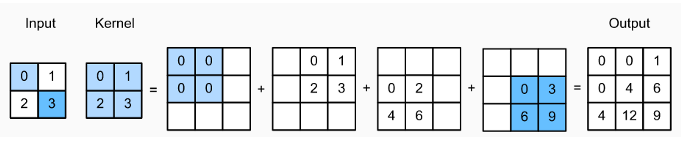

Applications of Transposed Convolution:

* 1)Super- Resolution
* 2)Semantic Segmentation

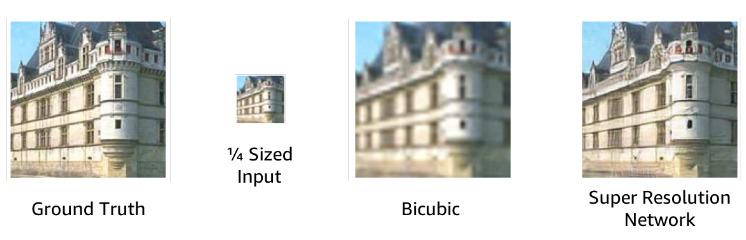

# **AutoEncoders**

Autoencoder is an unsupervised artificial neural network that learns how to efficiently compress and encode data then learns how to reconstruct the data back from the reduced encoded representation to a representation that is as close to the original input as possible.

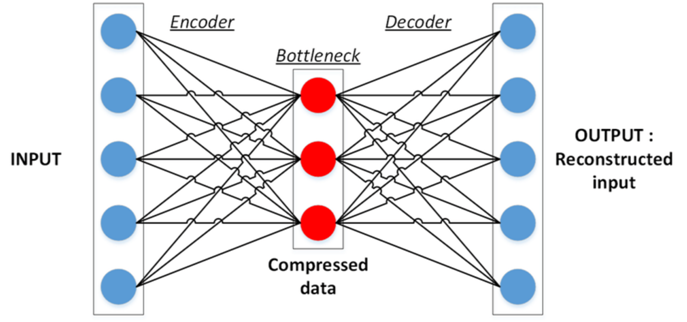

# Understanding AutoEncoders

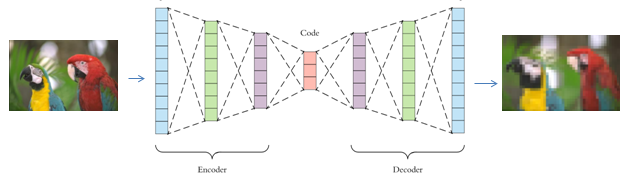

* Encoder: Encoder is just like a normla ANN model. In which the model learns how to reduce the input dimensions and compress the input data into an encoded representation.
* Bottleneck: Bottleneck is nothing but a hidden layer which contains the compressed representation of the input data.
* Decoder: In which the model learns how to reconstruct the data from the encoded representation to be as close to the original input as possible.
* Reconstruction Loss: This is the method that measures measure how well the decoder is performing and how close the output is to the original input.


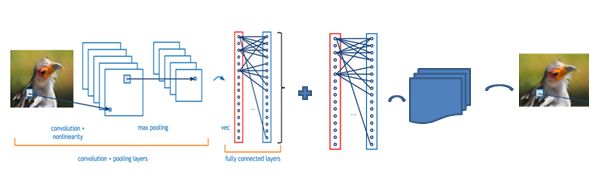

# Image Denoising

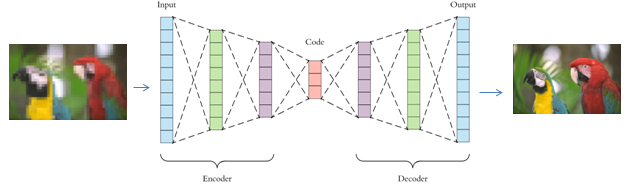

We can use AutoEncoders for denoising as well. Here we are passing noisy data to model as an input and training it to remove the noice from the data

# Data Generation

Just like GANs we can use AutoEncoders to generate data. And we can use that data(Noisy) to create robust models.

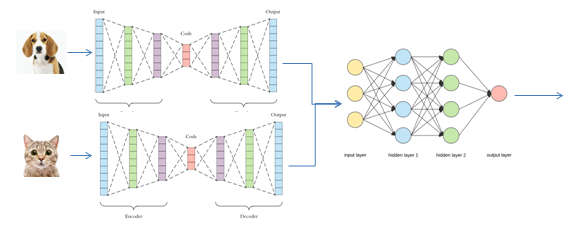


# Anomaly Approach

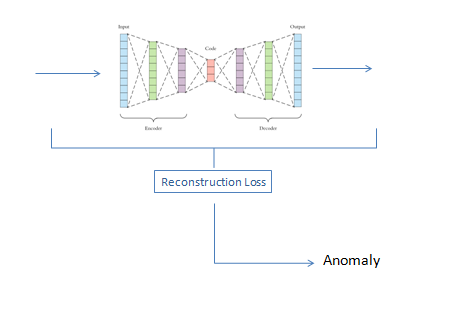

* Data description:
* Cloud Images - 100
* Non Cloud Images- 1499

* To find out anomaly(Cloud images) we will train our model only with non-anomaly(Non Cloud images) data. So that our model can understand non anomaly data more, than anomaly data. 

* When we train our model with non-anomaly data, Reconstruction loss will be less for non-anomaly data compared to anomaly data

# **Implementation of Autoencoder for anomaly detection**

*Loading the required Libraries*

In [8]:
import pandas as pd
import numpy as np
import math, re, os, cv2
import random
import gc
from tqdm import tqdm
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
print("Tensorflow version " + tf.__version__)
import tensorflow.keras.backend as K

from skimage.util import random_noise
from skimage.transform import rotate, AffineTransform, warp

Tensorflow version 2.16.1


In [21]:
#Path of cloud and Non-cloud datasets
path = os.path.expanduser('~/Downloads/all_image')


In [22]:
!pip install tqdm

In [25]:
import os
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from PIL import Image


#Loaded and Preprocessed all the non-cloud satellite images for training
all_images = []

img_list = os.listdir(path)
for i in tqdm(img_list):
    try:
        img_path = os.path.join(path, i)
        img = Image.open(img_path)
        img = img.resize((384,384))  # Resize if necessary
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = img / 255.  # Normalize pixel values
        all_images.append(img)
    except Exception as e:
        print(f"Error loading image {i}: {e}")

all_images = np.array(all_images)
print("Number of successfully loaded images:", len(all_images))
print("Shape of the loaded images array:", all_images.shape)

100%|█████████████████████████████████████████| 586/586 [00:29<00:00, 19.59it/s]


Number of successfully loaded images: 586
Shape of the loaded images array: (586, 384, 384, 3)


In [ ]:
#Show non-cloud images
n = 5
plt.figure(figsize= (20,10))

for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(all_images[i+50])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(all_images[i+20])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# Augment Non-cloud images

In [ ]:
def anticlockwise_rotation(image):
    angle= random.randint(0,180)
    return rotate(image, angle)

def clockwise_rotation(image):
    angle= random.randint(0,180)
    return rotate(image, -angle)

def h_flip(image):
    return  np.fliplr(image)

def v_flip(image):
    return np.flipud(image)

def add_noise(image):
    return random_noise(image)

def blur_image(image):
    return cv2.GaussianBlur(img, (9,9),0)

#I would not recommend warp_shifting, because it distorts image, but can be used in many use case like 
#classifying blur and non-blur images
def warp_shift(image): 
    transform = AffineTransform(translation=(0,40))  #chose x,y values according to your convinience
    warp_image = warp(image, transform, mode="wrap")
    return warp_image




In [ ]:
# aug_images=[]
# for i in tqdm(all_images):
#     img = add_noise(i)
#     img = blur_image(img)
#     img = warp_shift(img)
#     aug_images.append(img)
# aug_images = np.array(aug_images)

In [ ]:
# #Show Augmented non-cloud images
# n = 5
# plt.figure(figsize= (20,10))

# for i in range(n):
#     ax = plt.subplot(2, n, i+1)
#     plt.imshow(aug_images[i+50])
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)

#     ax = plt.subplot(2, n, i+1+n)
#     plt.imshow(aug_images[i+20])
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)

# plt.show()

In [ ]:
#Config hyperparameters
IMAGE_SIZE = [384,384]
SEED = 42
n_hidden_1 = 512
n_hidden_2 = 256
n_hidden_3 = 64 
n_hidden_4 = 16
n_hidden_5 = 8
convkernel = (3, 3)  # convolution kernel
poolkernel = (2, 2)  # pooling kernel

In [ ]:
#seeds
np.random.seed(SEED)
tf.random.set_seed(SEED)

# **Cofiguring TPU for Training**

In [ ]:

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)


# Customized autoencoder architecture

In [ ]:
def get_model():
    K.clear_session()
    with strategy.scope():
        inp1 = tf.keras.layers.Input(shape = (*IMAGE_SIZE, 3))

        x = tf.keras.layers.Conv2D(n_hidden_1, convkernel, activation='relu', padding='same')(inp1)
        x = tf.keras.layers.Conv2D(n_hidden_1, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.MaxPooling2D(poolkernel, padding='same')(x)#

        x = tf.keras.layers.Conv2D(n_hidden_2, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2D(n_hidden_2, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.MaxPooling2D(poolkernel, padding='same')(x)#

        x = tf.keras.layers.Conv2D(n_hidden_3, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2D(n_hidden_3, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2D(n_hidden_3, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2D(n_hidden_3, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.MaxPooling2D(poolkernel, padding='same')(x)#

        x = tf.keras.layers.Conv2D(n_hidden_4, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2D(n_hidden_4, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2D(n_hidden_4, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2D(n_hidden_4, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.MaxPooling2D(poolkernel, padding='same')(x)#

        x = tf.keras.layers.Conv2D(n_hidden_5, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2D(n_hidden_5, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2D(n_hidden_5, convkernel, activation='relu', padding='same')(x)
        encoded = tf.keras.layers.Conv2D(n_hidden_5, convkernel, activation='relu', padding='same')(x)


        #decoder
        x = tf.keras.layers.Conv2DTranspose(n_hidden_5, convkernel, strides=2, activation='relu', padding='same')(encoded)
        x = tf.keras.layers.Conv2DTranspose(n_hidden_4, convkernel, strides=2, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2DTranspose(n_hidden_3, convkernel, strides=2, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2DTranspose(n_hidden_2, convkernel, strides=2, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2DTranspose(n_hidden_1, convkernel, strides=1, activation='relu', padding='same')(x)

        decoded = tf.keras.layers.Conv2DTranspose(3, convkernel, activation="sigmoid", padding='same')(x)

        model = tf.keras.models.Model(inputs = inp1, outputs = decoded)

        opt = tfa.optimizers.RectifiedAdam(lr=3e-4)
        model.compile(
            optimizer = opt,
            loss = 'mse',
            metrics = [tf.keras.metrics.RootMeanSquaredError()]
        )

        return model

**Used Pretrained VGG19 for Encoder and Transposed convolution for Decoder**

In [ ]:
def get_vgg19():
    K.clear_session()
    with strategy.scope():
        image_input = tf.keras.layers.Input(shape = (*IMAGE_SIZE,3))
        vg19 = tf.keras.applications.VGG19(input_tensor = image_input, weights = 'imagenet', include_top=False)
        encoded = vg19.get_layer('block5_pool').output
        #decode
        x = tf.keras.layers.Conv2DTranspose(n_hidden_5, convkernel, strides=2, activation='relu', padding='same')(encoded)
        x = tf.keras.layers.Conv2DTranspose(n_hidden_4, convkernel, strides=2, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2DTranspose(n_hidden_3, convkernel, strides=2, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2DTranspose(n_hidden_2, convkernel, strides=2, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2DTranspose(n_hidden_1, convkernel, strides=2, activation='relu', padding='same')(x)
        decoded = tf.keras.layers.Conv2DTranspose(3, convkernel, activation="sigmoid", padding='same')(x)
        model = tf.keras.models.Model(inputs = image_input, outputs = decoded)
        opt = tfa.optimizers.RectifiedAdam(lr=3e-4)
        model.compile(
            optimizer = opt,
            loss = 'mse',
            metrics = [tf.keras.metrics.RootMeanSquaredError()]
        )
        return model

In [ ]:

model=  get_vgg19() #get_model()
model.summary()

In [ ]:
#Split the dataset into train and test with a ratio of 80:20.
X_train, X_test = train_test_split(all_images, test_size=0.2, random_state=SEED)
print(X_train.shape, X_test.shape)

In [ ]:
del all_images;  gc.collect()

In [ ]:
#model training config params
EPOCHS = 100
BATCH_SIZE = 16
NUM_TRAINING_IMAGES = X_train.shape[0]
steps = NUM_TRAINING_IMAGES // BATCH_SIZE
NUM_VALID_IMAGES = X_test.shape[0]
val_steps = NUM_VALID_IMAGES // BATCH_SIZE

In [ ]:
#Model training
sav = tf.keras.callbacks.ModelCheckpoint(
    
    'Enc'+'.h5', monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=True, mode='min', save_freq='epoch')
# lr scheduler
cb_lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.4, patience = 2,
                                                      verbose = 1, mode = 'min',min_delta = 0.0001)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 5, 
                                                  verbose = 1, min_delta = 0.0001)
model.fit(X_train, X_train,
      validation_data=(X_test, X_test),
      steps_per_epoch=steps,
      validation_steps=val_steps,
      epochs = EPOCHS,
      callbacks= [sav, cb_lr_schedule,early_stopping],
      verbose = 1)

 [Part 2: Satellite Anomaly Detection[Inference] ](https://www.kaggle.com/ashoksrinivas/satellite-anomaly-detection-inference)